This code is for EB (Matrix seed dispersal 30x20), Beta = 0.002, Gamma = (i+j)*k (Normalized)

In [1]:
#Libraries needed
import igraph as ig
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import statistics
import networkx as nx

In [2]:
########## Program #########
dir = os.getcwd()  # Folder where the program is
Experiment = 'SD_EB' #Name of the experiment
Long = 500 # Number of experiment
mu, sigma = 0.041, 0.0479  # Normal distribution for gamma
mu_beta, sigma_beta = 0.01, 0.002 # Normal distribution for beta
gamma_random = 0.002 # Value if a random negativa value is generated for gamma
beta_random = 0.002 # Value if a random negativa value is generated for beta
beta = 0.002
Normalized = 8 #Value to normalize the matrix
mu_edge, sigma_edge = 157.25, 76.8 # Values to generate random networks

In [3]:
MGL = [] #Matrix from the databases, narmalized
MCL = [] # Matrix from the databases, normalized and put in the form of (6) matrix from the paper 
VL = [] # Vector with the number of vertex of each web
D1 = [] # Vector with the dimension 1 of each web
D2 = [] # Equal to D1 but with dimension 2
databases = [] # Vector with the name of the databases to be used
MatrixGraphs = [] # Vector with graph matrix 
D1 = [] # Vector with dimension 1
D2 =[] # Vector with dimension 2
VL= [] # Vector with number of vertex
summatory = [] # Vector with the summation of rows and columns of the matrixes   

In [4]:
databases_dir = '/databases/M_SD_W'  # Directory of the databases

In [5]:
# This rutine allows to create a random matrix using pandas
for k in range(0,Long): 
    dim1 = 30
    filas = 30
    dim2 = 20
    cols = 20
    vertexs = dim1 + dim2
    edges = np.random.normal(2*mu_edge,2*sigma_edge,1)
    while (edges < 0 or edges > dim1*dim2):
        edges = np.random.normal(mu_edge,sigma_edge,1)
    randomGraph = nx.gnm_random_graph(vertexs,edges)
    randomGraph_ad = nx.adjacency_matrix(randomGraph)
    randomGraph_ad = randomGraph_ad.toarray()
    MatrixGraphP = pd.DataFrame(randomGraph_ad)
    #Create the matrix
    # Part of the cooperation
    for i in range(dim1):
        for j in range(dim1, vertexs):
            gamma = (i+1+j+1)*(k+1)
            gamma = gamma_random if gamma < 0 else gamma # If a random negative value is produced
            MatrixGraphP.loc[i,j] = MatrixGraphP.loc[i,j]*gamma #This part is what corresponds to the database now randomized 
            MatrixGraphP.loc[j,i] = MatrixGraphP.loc[j,i]*gamma #This part is what corresponds to the database now randomized
    summatory.append(MatrixGraphP.sum().sum())
    # Part of the competition
    for i in range(dim1):
        for j in range(dim1):
            MatrixGraphP.loc[i,j] = beta
        
    for i in range(vertexs-dim2, vertexs):
        for j in range(vertexs-dim2, vertexs):
            MatrixGraphP.loc[i,j] = beta
                
    #Diagonal
    for i in range(vertexs):
        MatrixGraphP.loc[i,i] = 0
    #MatrixGraphP.to_csv("Matrix.csv", sep = ";" )
    #Gathering all the data
    MatrixGraphs.append(MatrixGraphP)
    D1.append(dim1)
    D2.append(dim2)
    VL.append(vertexs)
        
    #MatrixGraphP.to_csv(dir + '/proof.csv', sep = ";")
            

In [6]:
# This rutine allows to generate matrices using pandas with this routine we put the betas and normalized gammas
Maximun = max(summatory)
for k in range(0,Long): 
    dim1 = 30
    filas = 30
    dim2 = 20
    cols = 20
    vertexs = dim1 + dim2
    MatrixGraphs[k] = Normalized*MatrixGraphs[k]/Maximun 
    for i in range(dim1):
        for j in range(dim1):
            MatrixGraphs[k].loc[i,j] = beta
        
    for i in range(vertexs-dim2, vertexs):
        for j in range(vertexs-dim2, vertexs):
            MatrixGraphs[k].loc[i,j] = beta
                
    #Diagonal
    for i in range(vertexs):
        MatrixGraphs[k].loc[i,i] = 0

In [7]:
# MatrixGraphP

In [8]:
for matrix in MatrixGraphs:
    MGL.append(matrix.copy())


In [9]:
# Montecarlo matrix
for matrix in MGL:
    MCL.append(matrix.copy())

for matrix in range(len(MCL)):
    # Gamma value are negatives
    for i in range(D1[matrix], VL[matrix]):
        for j in range(D1[matrix]):
            MCL[matrix].loc[i,j] = - MCL[matrix].loc[i,j]
            MCL[matrix].loc[j,i] = - MCL[matrix].loc[j,i]
    #Diagonal equal to 1
    for i in range( VL[matrix]):
        MCL[matrix].loc[i,i] = 1
        
    

In [10]:
#MCL[499]

In [11]:
#len(MCL)

In [12]:
# Generating the matrix to use in CgrilliJR
for i in range(0,len(MCL)): 
    textfile = open("databases_"+Experiment+"_flat/"+str(i)+"_In.lst", "w")
    Matrix = MCL[i].values.flatten()
    for element in Matrix:
        textfile.write(str(element) + "\n")
    textfile.close()

In [13]:
# Calling the program to calculate the structural stability
os.remove("Out_"+Experiment+".txt") if os.path.exists("Out_"+Experiment+".txt") else False
for i in range(0,len(MCL)):
    matrix = open("databases_"+Experiment+"_flat/"+str(i)+"_In.lst", "r")
    # subprocess.run(["./StructuralStab", str(VL[i]), "databases_flat/"+databases[i]+"_In.lst", databases[i]+"_Out.txt", "-1"], capture_output=False)
    subprocess.run(["./StructuralStab", str(VL[i]), "databases_"+Experiment+"_flat/"+str(i)+"_In.lst", "Out_"+Experiment+".txt", "-1"], capture_output=False)

In [14]:
# Reading the result
result = pd.read_csv("Out_"+Experiment+".txt",sep = " ", header = None)

In [15]:
List_Stab = result.to_numpy().transpose().tolist()

In [16]:
#List_Stab[2]

In [17]:
# Calculate mean grade and gamma minus beta
##Mean Grade
meangrade = []
for matrix in MGL:
    matrix_abs = matrix.copy()
    matrix_abs = matrix_abs.abs()
    meangrade_matrix = matrix_abs.sum().sum()/(2*matrix.shape[0])
    meangrade.append(meangrade_matrix)
    
## Gamma minus Beta
gammaminusbeta = []
for matrix in MCL:
    gammaminusbeta_matrix = (-matrix.sum().sum() + matrix.shape[0])/(2*matrix.shape[0])
    gammaminusbeta.append(gammaminusbeta_matrix)
    

In [18]:
#meangrade

In [19]:
#gammaminusbeta

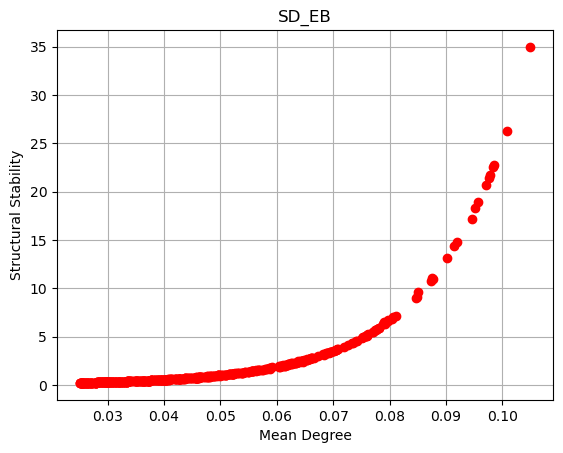

In [20]:
# Generating Plots of meangrade
plt.plot(meangrade, List_Stab[2], "ro")
plt.xlabel('Mean Degree')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

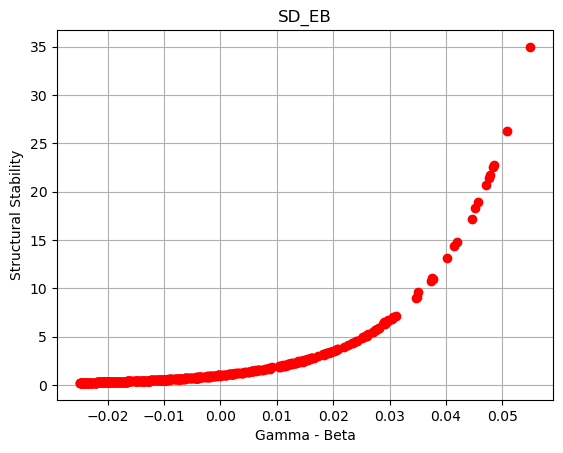

In [21]:
# Generating Plots of gammaminusbeta
plt.plot(gammaminusbeta, List_Stab[2], "ro")
plt.xlabel('Gamma - Beta')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()
    

In [22]:
# Calculate sum of cooperation and competition
sum_coop = [] # Sum of cooperation
sum_comp = [] # Sum of competition
for matrix in MCL:
    suma = (matrix.values).tolist()
    sum_comp_rel = []
    sum_coop_rel = []
    for vector in suma:
        sum_comp_rel.append(sum([comp for comp in vector if (comp >0 and comp != 1.0)]))
        sum_coop_rel.append(sum([coop for coop in vector if coop <=0]))
    sum_comp.append(sum(sum_comp_rel)/(2*matrix.shape[0]))
    sum_coop.append(-sum(sum_coop_rel)/(2*matrix.shape[0]))

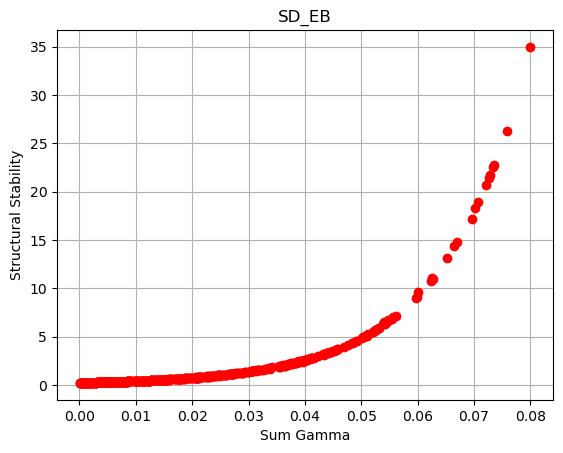

In [23]:
# Generating Plots of sum of gamma
plt.plot(sum_coop, List_Stab[2], "ro")
plt.xlabel('Sum Gamma')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

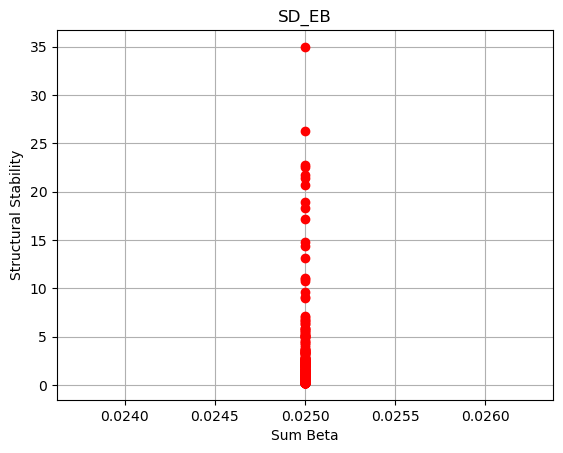

In [24]:
# Generating Plots of sum of gamma
plt.plot(sum_comp, List_Stab[2], "ro")
plt.xlabel('Sum Beta')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

In [25]:
# Modularity review
Modul_eig = []
Modul_opt = []
Modul_greedy = []
for i in range(0,len(MGL)):
    print(i)
    Graph = MGL[i].values
    g = ig.Graph.Weighted_Adjacency((Graph).tolist(), mode = 'undirected')
    print('eigen')
    communities_eig = g.community_leading_eigenvector(weights = g.es['weight'])
    print('opt')
    #communities_opt = g.community_optimal_modularity(weights = g.es['weight'])
    #Not possible to compute, too much time
    print('fast greedy')
    communities_greedy = g.community_fastgreedy(weights = g.es['weight']).as_clustering()
    modula_eig = g.modularity(communities_eig)
    modula_opt = 1#g.modularity(communities_opt)
    modula_greedy = g.modularity(communities_greedy)
    Modul_eig.append(modula_eig)
    Modul_opt.append(modula_opt)
    Modul_greedy.append(modula_greedy)

0
eigen
opt
fast greedy
1
eigen
opt
fast greedy
2
eigen
opt
fast greedy
3
eigen
opt
fast greedy
4
eigen
opt
fast greedy
5
eigen
opt
fast greedy
6
eigen
opt
fast greedy
7
eigen
opt
fast greedy
8
eigen
opt
fast greedy
9
eigen
opt
fast greedy
10
eigen
opt
fast greedy
11
eigen
opt
fast greedy
12
eigen
opt
fast greedy
13
eigen
opt
fast greedy
14
eigen
opt
fast greedy
15
eigen
opt
fast greedy
16
eigen
opt
fast greedy
17
eigen
opt
fast greedy
18
eigen
opt
fast greedy
19
eigen
opt
fast greedy
20
eigen
opt
fast greedy
21
eigen
opt
fast greedy
22
eigen
opt
fast greedy
23
eigen
opt
fast greedy
24
eigen
opt
fast greedy
25
eigen
opt
fast greedy
26
eigen
opt
fast greedy
27
eigen
opt
fast greedy
28
eigen
opt
fast greedy
29
eigen
opt
fast greedy
30
eigen
opt
fast greedy
31
eigen
opt
fast greedy
32
eigen
opt
fast greedy
33
eigen
opt
fast greedy
34
eigen
opt
fast greedy
35
eigen
opt
fast greedy
36
eigen
opt
fast greedy
37
eigen
opt
fast greedy
38
eigen
opt
fast greedy
39
eigen
opt
fast greedy
40
eigen
o

opt
fast greedy
337
eigen
opt
fast greedy
338
eigen
opt
fast greedy
339
eigen
opt
fast greedy
340
eigen
opt
fast greedy
341
eigen
opt
fast greedy
342
eigen
opt
fast greedy
343
eigen
opt
fast greedy
344
eigen
opt
fast greedy
345
eigen
opt
fast greedy
346
eigen
opt
fast greedy
347
eigen
opt
fast greedy
348
eigen
opt
fast greedy
349
eigen
opt
fast greedy
350
eigen
opt
fast greedy
351
eigen
opt
fast greedy
352
eigen
opt
fast greedy
353
eigen
opt
fast greedy
354
eigen
opt
fast greedy
355
eigen
opt
fast greedy
356
eigen
opt
fast greedy
357
eigen
opt
fast greedy
358
eigen
opt
fast greedy
359
eigen
opt
fast greedy
360
eigen
opt
fast greedy
361
eigen
opt
fast greedy
362
eigen
opt
fast greedy
363
eigen
opt
fast greedy
364
eigen
opt
fast greedy
365
eigen
opt
fast greedy
366
eigen
opt
fast greedy
367
eigen
opt
fast greedy
368
eigen
opt
fast greedy
369
eigen
opt
fast greedy
370
eigen
opt
fast greedy
371
eigen
opt
fast greedy
372
eigen
opt
fast greedy
373
eigen
opt
fast greedy
374
eigen
opt
fast gre

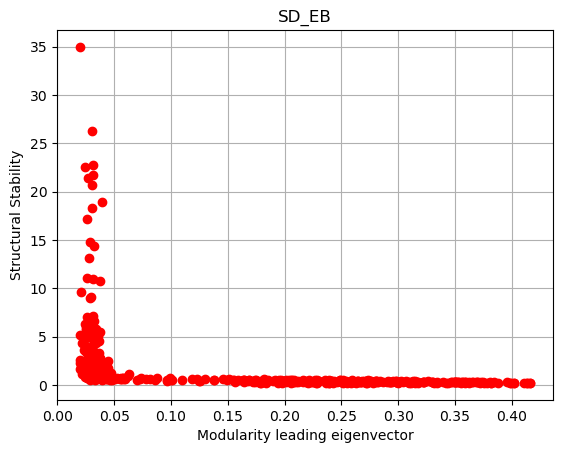

In [26]:
# Generating plots modularity
plt.plot(Modul_eig, List_Stab[2], "ro")
plt.xlabel('Modularity leading eigenvector')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

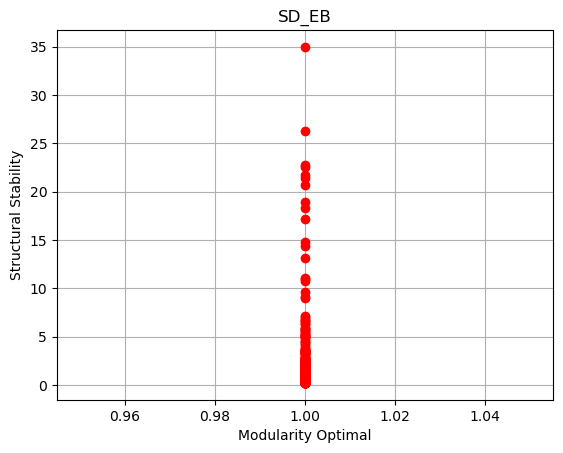

In [27]:
# Generating plots modularity
plt.plot(Modul_opt, List_Stab[2], "ro")
plt.xlabel('Modularity Optimal')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

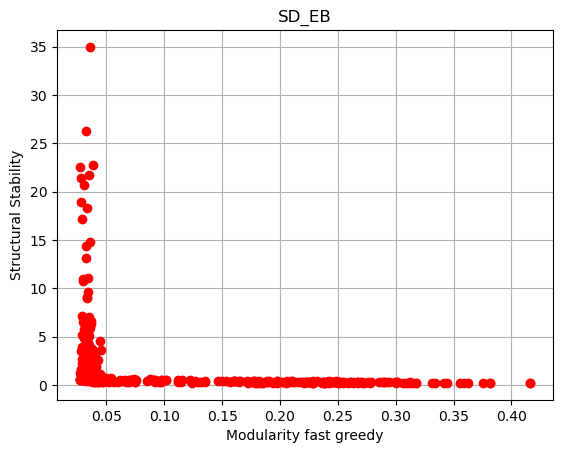

In [28]:
# Generating plots modularity
plt.plot(Modul_greedy, List_Stab[2], "ro")
plt.xlabel('Modularity fast greedy')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

In [29]:
## Save the results in a CSV to compare
databases = range(0, Long)
data = np.transpose(np.array([databases, meangrade, gammaminusbeta, sum_coop, sum_comp, 
                              Modul_eig, Modul_opt, Modul_greedy, List_Stab[2]]))

In [30]:
df_data = pd.DataFrame(data, columns = ['database','meangrade', 'gammaminusbeta', 'sum_coop', 'sum_comp',
                                        'Modularity_eig','Modularity_opt', 'Modularity_greedy','Struc_Stab'])

In [31]:
#df_data

In [32]:
df_data.to_csv('Result_CSV/'+Experiment+'.csv', index = False)